# 1. Project Overview 
This project analyzes the relationship between salary, education, and occupation across U.S. states using data from the Bureau of Labor Statistics (BLS) and the U.S. Census. The goal is to understand how these factors influence job opportunities and income levels in different geographical areas.

# 2.  Data Preparation


In [1]:
# loading libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime


## BLS Data Preparation

In [2]:
# Load the data using pandas
bls_data=pd.read_excel("./Data_Resources/bls_data.xlsx")
# Preview the first few rows to check if the data is being read correctly
display(bls_data.head(3))

AREA AREA_TITLE  AREA_TYPE PRIM_STATE   NAICS     NAICS_TITLE  \
0    99       U.S.          1         US  000000  Cross-industry   
1    99       U.S.          1         US  000000  Cross-industry   
2    99       U.S.          1         US  000000  Cross-industry   

          I_GROUP  OWN_CODE OCC_CODE               OCC_TITLE  ... H_MEDIAN  \
0  cross-industry      1235  00-0000         All Occupations  ...    23.11   
1  cross-industry      1235  11-0000  Management Occupations  ...    56.19   
2  cross-industry      1235  11-1000          Top Executives  ...    49.74   

  H_PCT75 H_PCT90 A_PCT10 A_PCT25 A_MEDIAN A_PCT75 A_PCT90 ANNUAL HOURLY  
0   37.01    58.4   29050   35660    48060   76980  121470    NaN    NaN  
1   81.29  111.36   54550   78330   116880  169090  231620    NaN    NaN  
2   79.57       #   46400   66170   103460  165500       #    NaN    NaN  

[3 rows x 32 columns]

In [3]:
# check the columns names:
bls_data.columns

Index(['AREA', 'AREA_TITLE', 'AREA_TYPE', 'PRIM_STATE', 'NAICS', 'NAICS_TITLE',
       'I_GROUP', 'OWN_CODE', 'OCC_CODE', 'OCC_TITLE', 'O_GROUP', 'TOT_EMP',
       'EMP_PRSE', 'JOBS_1000', 'LOC_QUOTIENT', 'PCT_TOTAL', 'PCT_RPT',
       'H_MEAN', 'A_MEAN', 'MEAN_PRSE', 'H_PCT10', 'H_PCT25', 'H_MEDIAN',
       'H_PCT75', 'H_PCT90', 'A_PCT10', 'A_PCT25', 'A_MEDIAN', 'A_PCT75',
       'A_PCT90', 'ANNUAL', 'HOURLY'],
      dtype='object')

In [4]:
# Select the relevant columns from the DataFrame
relevant_columns = [
    'AREA_TITLE', 'OCC_CODE', 'OCC_TITLE', 'TOT_EMP', 'PRIM_STATE',
    'H_MEAN', 'A_MEAN', 'H_MEDIAN', 'A_MEDIAN'
]
# Subset the DataFrame 
bls_df = bls_data[relevant_columns]
bls_df.head()

AREA_TITLE OCC_CODE               OCC_TITLE    TOT_EMP PRIM_STATE  H_MEAN  \
0       U.S.  00-0000         All Occupations  151853870         US   31.48   
1       U.S.  11-0000  Management Occupations   10495770         US   66.23   
2       U.S.  11-1000          Top Executives    3751510         US   65.43   
3       U.S.  11-1010        Chief Executives     211230         US  124.47   
4       U.S.  11-1011        Chief Executives     211230         US  124.47   

   A_MEAN H_MEDIAN A_MEDIAN  
0   65470    23.11    48060  
1  137750    56.19   116880  
2  136100    49.74   103460  
3  258900    99.37   206680  
4  258900    99.37   206680

In [5]:
#check the dtypes of the df
bls_df.dtypes

AREA_TITLE    object
OCC_CODE      object
OCC_TITLE     object
TOT_EMP       object
PRIM_STATE    object
H_MEAN        object
A_MEAN        object
H_MEDIAN      object
A_MEDIAN      object
dtype: object

In [6]:
# Convert numeric columns to appropriate types (handle errors in conversion)
numeric_columns = ['TOT_EMP', 'H_MEAN', 'A_MEAN', 'H_MEDIAN', 'A_MEDIAN']
# Convert specified columns to numeric, handling errors with 'coerce'
bls_df.loc[:,numeric_columns] = bls_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Preview the cleaned data
bls_df.head()


C:\Users\Sami\AppData\Local\Temp\ipykernel_387928\4206975348.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bls_df.loc[:,numeric_columns] = bls_df[numeric_columns].apply(pd.to_numeric, errors='coerce')


AREA_TITLE OCC_CODE               OCC_TITLE      TOT_EMP PRIM_STATE  H_MEAN  \
0       U.S.  00-0000         All Occupations  151853870.0         US   31.48   
1       U.S.  11-0000  Management Occupations   10495770.0         US   66.23   
2       U.S.  11-1000          Top Executives    3751510.0         US   65.43   
3       U.S.  11-1010        Chief Executives     211230.0         US  124.47   
4       U.S.  11-1011        Chief Executives     211230.0         US  124.47   

     A_MEAN H_MEDIAN  A_MEDIAN  
0   65470.0    23.11   48060.0  
1  137750.0    56.19  116880.0  
2  136100.0    49.74  103460.0  
3  258900.0    99.37  206680.0  
4  258900.0    99.37  206680.0

In [7]:
#recheck the data type
bls_df.dtypes

AREA_TITLE    object
OCC_CODE      object
OCC_TITLE     object
TOT_EMP       object
PRIM_STATE    object
H_MEAN        object
A_MEAN        object
H_MEDIAN      object
A_MEDIAN      object
dtype: object

In [8]:
#  Ensure that AREA_TITLE, and OCC_TITLE have consistent formatting 
#str.strip to Remove leading/trailing spaces and str.title to standardize case
bls_df.loc[:,'AREA_TITLE'] = bls_df['AREA_TITLE'].str.strip().str.title()#strip spaces and standardize text formatting 
bls_df.loc[:,'OCC_TITLE'] = bls_df['OCC_TITLE'].str.strip().str.title()


In [9]:
# Remove hyphen and the invalid code from the OCC_CODE column
bls_df.loc[:,'OCC_CODE'] = bls_df['OCC_CODE'].str.replace('-', '', regex=False).replace('', np.nan).dropna()

In [10]:
# Get the unique values for each column in the DataFrame
unique_values = bls_df.apply(lambda x: x.unique())

# Display the unique values for each column
print(unique_values)

AREA_TITLE    [U.S., Alabama, Alaska, Arizona, Arkansas, Cal...
OCC_CODE      [000000, 110000, 111000, 111010, 111011, 11102...
OCC_TITLE     [All Occupations, Management Occupations, Top ...
TOT_EMP       [151853870.0, 10495770.0, 3751510.0, 211230.0,...
PRIM_STATE    [US, AL, AK, AZ, AR, CA, CO, CT, DE, DC, FL, G...
H_MEAN        [31.48, 66.23, 65.43, 124.47, 62.18, nan, 76.9...
A_MEAN        [65470.0, 137750.0, 136100.0, 258900.0, 129330...
H_MEDIAN      [23.11, 56.19, 49.74, 99.37, 48.69, nan, 67.23...
A_MEDIAN      [48060.0, 116880.0, 103460.0, 206680.0, 101280...
dtype: object


In [11]:
#check and count the missing values
missing_values=bls_df.isna().sum()
missing_values

AREA_TITLE        0
OCC_CODE          0
OCC_TITLE         0
TOT_EMP       11598
PRIM_STATE        0
H_MEAN        20964
A_MEAN         5352
H_MEDIAN      23059
A_MEDIAN       7474
dtype: int64

In [12]:
#drop all the missing values from  the data
bls_df=bls_df.dropna(how='any')
# check all the remove values
bls_df.shape
# bls_df.isna().sum()

(378880, 9)

In [13]:
# ensure to keep only the 50 us state while excluding the others 
unwanted_state=['GU','PR','VI','DC']
bls_clean=bls_df[~bls_df['PRIM_STATE'].isin(unwanted_state)]
bls_clean['PRIM_STATE'].unique()

array(['US', 'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

In [14]:
# filter dataset to include only rows where the annual mean wage (A_MEAN) or hourly wage (H_MEAN) exceeds the equivalent of $100K per year.
bls_clean = bls_clean[(bls_clean['A_MEAN'] >= 100000) | (bls_clean['H_MEAN'] >= 48.08)]
bls_clean.tail(2)

AREA_TITLE OCC_CODE       OCC_TITLE  \
412118    Southwest Louisiana Nonmetropolitan Area   535031  Ship Engineers   
412119  Southwest Mississippi Nonmetropolitan Area   535031  Ship Engineers   

       TOT_EMP PRIM_STATE H_MEAN    A_MEAN H_MEDIAN  A_MEDIAN  
412118    90.0         LA  54.82  114020.0    52.71  109630.0  
412119    40.0         MS  55.86  116200.0    61.22  127330.0

 
### Distinguish between National-Level Data and State-Level Data:

- We noticed that the national-level data is identified under the PRIM_STATE column as 'US', and the AREA_TITLE typically mentions 'U.S.' to indicate that the row represents data aggregated for the entire U.S. rather than a specific state.

- State-Level Data: All other rows represent state-specific data, where the PRIM_STATE column corresponds to the state abbreviation (like 'CA' for California, 'TX' for Texas, etc.)


In [15]:
# Create a new column 'LEVEL' to tag national data based on 'PRIM_STATE' and 'AREA_TITLE'
bls_clean.loc[:,'LEVEL'] = bls_clean.apply(
    lambda row: 'National' if row['PRIM_STATE'] == 'US' and 'U.S.' in row['AREA_TITLE'] else 'State', 
    axis=1
)

# Preview to check the tagging
bls_clean[['PRIM_STATE', 'AREA_TITLE', 'LEVEL']].head()


PRIM_STATE AREA_TITLE     LEVEL
1         US       U.S.  National
2         US       U.S.  National
3         US       U.S.  National
4         US       U.S.  National
5         US       U.S.  National

- Data Integrity: 
By tagging the national and state data explicitly, we ensure that the national-level data is treated separately, avoiding issues when conducting state-level analyses or visualizations.

In [16]:
# Isolate state-level data and national-level analysis for comparison.
bls_state_data = bls_clean[bls_clean['LEVEL'] == 'State']
National_data=bls_clean[bls_clean['LEVEL']=='National']
display(bls_state_data.head())
display(National_data.head())

AREA_TITLE OCC_CODE               OCC_TITLE    TOT_EMP PRIM_STATE  \
177552     Alabama   110000  Management Occupations   105580.0         AL   
177553      Alaska   110000  Management Occupations    23750.0         AK   
177554     Arizona   110000  Management Occupations   232000.0         AZ   
177556  California   110000  Management Occupations  1308800.0         CA   
177557    Colorado   110000  Management Occupations   156700.0         CO   

       H_MEAN    A_MEAN H_MEDIAN  A_MEDIAN  LEVEL  
177552  56.21  116920.0    47.95   99740.0  State  
177553  59.74  124260.0    52.25  108680.0  State  
177554  59.53  123820.0    49.31  102560.0  State  
177556   77.1  160360.0    65.31  135840.0  State  
177557  74.99  155970.0    65.95  137170.0  State

AREA_TITLE OCC_CODE                        OCC_TITLE     TOT_EMP PRIM_STATE  \
1       U.S.   110000           Management Occupations  10495770.0         US   
2       U.S.   111000                   Top Executives   3751510.0         US   
3       U.S.   111010                 Chief Executives    211230.0         US   
4       U.S.   111011                 Chief Executives    211230.0         US   
5       U.S.   111020  General And Operations Managers   3507810.0         US   

   H_MEAN    A_MEAN H_MEDIAN  A_MEDIAN     LEVEL  
1   66.23  137750.0    56.19  116880.0  National  
2   65.43  136100.0    49.74  103460.0  National  
3  124.47  258900.0    99.37  206680.0  National  
4  124.47  258900.0    99.37  206680.0  National  
5   62.18  129330.0    48.69  101280.0  National

In [17]:
# check  the type after data split
bls_state_data.dtypes

AREA_TITLE    object
OCC_CODE      object
OCC_TITLE     object
TOT_EMP       object
PRIM_STATE    object
H_MEAN        object
A_MEAN        object
H_MEDIAN      object
A_MEDIAN      object
LEVEL         object
dtype: object

In [18]:
# Convert specified columns to numeric, handling errors with 'coerce'
bls_state_data[numeric_columns] =bls_state_data[numeric_columns].apply(pd.to_numeric, errors='coerce')
# Preview the cleaned data
bls_state_data.head()

C:\Users\Sami\AppData\Local\Temp\ipykernel_387928\144381960.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bls_state_data[numeric_columns] =bls_state_data[numeric_columns].apply(pd.to_numeric, errors='coerce')


AREA_TITLE OCC_CODE               OCC_TITLE    TOT_EMP PRIM_STATE  \
177552     Alabama   110000  Management Occupations   105580.0         AL   
177553      Alaska   110000  Management Occupations    23750.0         AK   
177554     Arizona   110000  Management Occupations   232000.0         AZ   
177556  California   110000  Management Occupations  1308800.0         CA   
177557    Colorado   110000  Management Occupations   156700.0         CO   

        H_MEAN    A_MEAN  H_MEDIAN  A_MEDIAN  LEVEL  
177552   56.21  116920.0     47.95   99740.0  State  
177553   59.74  124260.0     52.25  108680.0  State  
177554   59.53  123820.0     49.31  102560.0  State  
177556   77.10  160360.0     65.31  135840.0  State  
177557   74.99  155970.0     65.95  137170.0  State

In [19]:
#check the data types
bls_state_data.dtypes

AREA_TITLE     object
OCC_CODE       object
OCC_TITLE      object
TOT_EMP       float64
PRIM_STATE     object
H_MEAN        float64
A_MEAN        float64
H_MEDIAN      float64
A_MEDIAN      float64
LEVEL          object
dtype: object

In [20]:
# Summary statistics for numerical columns
bls_state_data.describe()


TOT_EMP        H_MEAN         A_MEAN      H_MEDIAN       A_MEDIAN
count  2.349600e+04  23496.000000   23496.000000  23496.000000   23496.000000
mean   3.572314e+03     62.556502  130116.438968     57.327481  119240.223868
std    2.695079e+04     15.413664   32060.421687     14.120349   29370.385342
min    3.000000e+01     48.080000  100000.000000     16.240000   33780.000000
25%    9.000000e+01     52.307500  108790.000000     48.390000  100660.000000
50%    2.200000e+02     57.990000  120620.000000     53.100000  110440.000000
75%    9.600000e+02     66.760000  138850.000000     62.650000  130310.000000
max    1.308800e+06    194.280000  404100.000000    114.930000  239060.000000

In [21]:
# check the data structure
bls_state_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23496 entries, 177552 to 412119
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AREA_TITLE  23496 non-null  object 
 1   OCC_CODE    23496 non-null  object 
 2   OCC_TITLE   23496 non-null  object 
 3   TOT_EMP     23496 non-null  float64
 4   PRIM_STATE  23496 non-null  object 
 5   H_MEAN      23496 non-null  float64
 6   A_MEAN      23496 non-null  float64
 7   H_MEDIAN    23496 non-null  float64
 8   A_MEDIAN    23496 non-null  float64
 9   LEVEL       23496 non-null  object 
dtypes: float64(5), object(5)
memory usage: 2.0+ MB


## Census Data Preparation

In [22]:
#load data
census_data = pd.read_csv("./Data_Resources/census_data.csv",delimiter=',')
# check data
census_data.head()

REGION  STATEICP  SEX  AGE  EDUC  EDUCD  GRADEATT  GRADEATTD  DEGFIELD  \
0      32        41    1   41     6     63         0          0         0   
1      32        41    1   21     7     71         0          0         0   
2      32        41    2   19     7     71         6         60         0   
3      32        41    2   51     8     81         0          0         0   
4      32        41    1   20     6     65         6         60         0   

   DEGFIELDD  ...  QINCOTHE  QINCRETI  QINCSS QINCTOT  QINCWAGE QINCWELF  \
0          0  ...         0         0       0       0         0        0   
1          0  ...         0         0       0       0         0        0   
2          0  ...         4         4       4       4         4        4   
3          0  ...         0         0       0       0         0        0   
4          0  ...         4         4       4       4         4        4   

   QPWSTAT2  US2022C_WAGP  US2022C_OCCP  US2022C_POWSP  
0         0         24000          7330              1  
1         0         29000          3870              1  
2         4          4500          5400              1  
3         4         30000          5840              1  
4         4         17000          4020              1  

[5 rows x 40 columns]

In [23]:
#Check the columns names
census_data.columns

Index(['REGION', 'STATEICP', 'SEX', 'AGE', 'EDUC', 'EDUCD', 'GRADEATT',
       'GRADEATTD', 'DEGFIELD', 'DEGFIELDD', 'EMPSTAT', 'EMPSTATD', 'OCC',
       'OCCSOC', 'IND', 'INDNAICS', 'INCTOT', 'INCWAGE', 'OCCSCORE',
       'PWSTATE2', 'QAGE', 'QSEX', 'QEDUC', 'QGRADEAT', 'QDEGFIELD',
       'QEMPSTAT', 'QIND', 'QOCC', 'QINCBUS', 'QINCINVS', 'QINCOTHE',
       'QINCRETI', 'QINCSS', 'QINCTOT', 'QINCWAGE', 'QINCWELF', 'QPWSTAT2',
       'US2022C_WAGP', 'US2022C_OCCP', 'US2022C_POWSP'],
      dtype='object')

In [24]:
# filtre the data  to only keep the relevant columns
relevant_c = ['STATEICP' ,'OCCSOC', 'INCTOT', 'EDUCD','SEX', 'AGE']
census_data=census_data[relevant_c]
census_data.head()

STATEICP  OCCSOC  INCTOT  EDUCD  SEX  AGE
0        41  49904X   28057     63    1   41
1        41  333050   33903     71    1   21
2        41  434171    5261     71    2   19
3        41  439041   35072     81    2   51
4        41  352010   19874     65    1   20

In [25]:
# Remove any non-numeric characters and ensure all codes are exactly 6 digits by padding with leading zeros
census_data.loc[:, 'OCCSOC'] = census_data['OCCSOC'].str.extract('(\d+)', expand=False).str.zfill(6)

In [26]:
#Replace all occurrences of 1 with "Male" and 2 with "Female" in the SEX column.#
census_data.loc[:,'SEX'] = census_data['SEX'].astype(str).replace({'1': 'Male', '2': 'Female'})

C:\Users\Sami\AppData\Local\Temp\ipykernel_387928\1833119181.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Male' 'Male' 'Female' ... 'Female' 'Male' 'Female']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  census_data.loc[:,'SEX'] = census_data['SEX'].astype(str).replace({'1': 'Male', '2': 'Female'})


In [27]:
# Display the data Structure 
census_data.head()

STATEICP  OCCSOC  INCTOT  EDUCD     SEX  AGE
0        41  049904   28057     63    Male   41
1        41  333050   33903     71    Male   21
2        41  434171    5261     71  Female   19
3        41  439041   35072     81  Female   51
4        41  352010   19874     65    Male   20

In [28]:
# Mapping of numeric state codes to their respective state abbreviations
census_df=census_data.copy()
state_code_to_abbr = {
    1: 'CT',2: 'ME', 3: 'MA',4: 'NH', 5: 'RI', 6: 'VT',11: 'DE', 12: 'NJ', 13: 'NY',14: 'PA', 21: 'IL',22: 'IN', 23: 'MI', 24: 'OH', 
    25: 'WI', 31: 'IA',32: 'KS',33: 'MN',34: 'MO', 35: 'NE',36: 'ND',37: 'SD',40: 'VA', 41: 'AL',42: 'AR', 43: 'FL',
    44: 'GA',45: 'LA',46: 'MS',47: 'NC',48: 'SC',49: 'TX', 51: 'KY', 52: 'MD', 53: 'OK', 54: 'TN', 56: 'WV', 61: 'AZ',               
    62: 'CO',63: 'ID', 64: 'MT', 65: 'NV', 66: 'NM', 67: 'UT', 68: 'WY', 71: 'CA', 72: 'OR', 73: 'WA', 81: 'AK', 82: 'HI'
}

# apply the map on the Data
census_df.loc[:,'PRIM_STATE']=census_df['STATEICP'].map(state_code_to_abbr)

In [29]:
# Dictionary to map STATEICP codes to state names (50 U.S. states only)
state_map = {
    1: 'Connecticut', 2: 'Maine',3: 'Massachusetts',4: 'New Hampshire',5: 'Rhode Island',6: 'Vermont',
    11: 'Delaware',12: 'New Jersey',13: 'New York',14: 'Pennsylvania',21: 'Illinois',22: 'Indiana',23: 'Michigan',24: 'Ohio',25: 'Wisconsin',
    31: 'Iowa',32: 'Kansas',33: 'Minnesota',34: 'Missouri',35: 'Nebraska',36: 'North Dakota',37: 'South Dakota',40: 'Virginia',41: 'Alabama',
    42: 'Arkansas',43: 'Florida',44: 'Georgia',45: 'Louisiana',46: 'Mississippi',47: 'North Carolina',48: 'South Carolina',49: 'Texas',
    51: 'Kentucky',52: 'Maryland',53: 'Oklahoma',54: 'Tennessee',56: 'West Virginia',61: 'Arizona',62: 'Colorado',63: 'Idaho',64: 'Montana',65: 'Nevada',
    66: 'New Mexico',67: 'Utah',68: 'Wyoming', 71: 'California',72: 'Oregon',73: 'Washington',81: 'Alaska', 82: 'Hawaii'
}
# apply the map on the Data
census_df.loc[:,'STATE_NAME']=census_df['STATEICP'].map(state_map)


In [30]:
# Education map for the provided codes
education_map = {
    63: "No schooling", 
    71: "Nursery to grade 4", 
    81: "Kindergarten", 
    65: "Grade 1 to 4", 
    101: "Grade 5 to 8", 
    40: "Grade 9", 
    64: "Grade 10", 
    50: "Grade 11", 
    30: "Grade 12, no diploma", 
    17: "High school graduate", 
    61: "Some college", 
    16: "1 year of college", 
    114: "Associate's degree", 
    116: "Bachelor's degree", 
    115: "Master's degree", 
    25: "Professional degree", 
    26: "Doctoral degree", 
    22: "Missing"
}

# Apply the mapping again
census_df['EDUCATION_LABEL'] = census_df['EDUCD'].map(education_map)

In [31]:
# recheck the Data structure 
census_df.head()

STATEICP  OCCSOC  INCTOT  EDUCD     SEX  AGE PRIM_STATE STATE_NAME  \
0        41  049904   28057     63    Male   41         AL    Alabama   
1        41  333050   33903     71    Male   21         AL    Alabama   
2        41  434171    5261     71  Female   19         AL    Alabama   
3        41  439041   35072     81  Female   51         AL    Alabama   
4        41  352010   19874     65    Male   20         AL    Alabama   

      EDUCATION_LABEL  
0        No schooling  
1  Nursery to grade 4  
2  Nursery to grade 4  
3        Kindergarten  
4        Grade 1 to 4

In [32]:
# check missing  values
census_df.isna().sum()

STATEICP               0
OCCSOC                 0
INCTOT                 0
EDUCD                  0
SEX                    0
AGE                    0
PRIM_STATE             0
STATE_NAME             0
EDUCATION_LABEL    41220
dtype: int64

In [33]:
#Drop missing valeus
census_df=census_df.dropna(subset=['EDUCATION_LABEL'])

In [34]:
# Filter for individuals earning $100K or more
census_df = census_df[census_df['INCTOT'] >= 100000]

In [35]:
#drop the INCTOT beccause the first dataset contains :H_MEAN, A_MEAN, etc. that provide sufficient information about income,
#  it may be unnecessary to keep it.
census_df.drop(columns=['INCTOT'],inplace=True)

In [36]:
# display some of data
display(census_df.tail())

STATEICP  OCCSOC  EDUCD     SEX  AGE PRIM_STATE STATE_NAME  \
7022531        68  291123    116  Female   41         WY    Wyoming   
7022534        68  001191    114    Male   62         WY    Wyoming   
7022538        68  002310    115    Male   62         WY    Wyoming   
7022545        68  419020     81  Female   47         WY    Wyoming   
7022551        68  492020     63    Male   66         WY    Wyoming   

            EDUCATION_LABEL  
7022531   Bachelor's degree  
7022534  Associate's degree  
7022538     Master's degree  
7022545        Kindergarten  
7022551        No schooling

In [37]:
# rename the occupation code
census_df=census_df.rename(columns={'OCCSOC':'OCC_CODE'})

## 3. Data Merging :Combining Census and BLS Data

In [38]:
#create a combined data contains all the columns but only for the rows where there is a match on both PRIM_STATE and OCC_CODE.
merged_df=bls_state_data.merge(census_df,on=['PRIM_STATE','OCC_CODE'],how='inner')

In [39]:
# check if is there any missing values before procedding 
merged_df.isna().sum()

AREA_TITLE         0
OCC_CODE           0
OCC_TITLE          0
TOT_EMP            0
PRIM_STATE         0
H_MEAN             0
A_MEAN             0
H_MEDIAN           0
A_MEDIAN           0
LEVEL              0
STATEICP           0
EDUCD              0
SEX                0
AGE                0
STATE_NAME         0
EDUCATION_LABEL    0
dtype: int64

In [40]:
#check the data Structure 
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5438150 entries, 0 to 5438149
Data columns (total 16 columns):
 #   Column           Dtype  
---  ------           -----  
 0   AREA_TITLE       object 
 1   OCC_CODE         object 
 2   OCC_TITLE        object 
 3   TOT_EMP          float64
 4   PRIM_STATE       object 
 5   H_MEAN           float64
 6   A_MEAN           float64
 7   H_MEDIAN         float64
 8   A_MEDIAN         float64
 9   LEVEL            object 
 10  STATEICP         int64  
 11  EDUCD            int64  
 12  SEX              object 
 13  AGE              int64  
 14  STATE_NAME       object 
 15  EDUCATION_LABEL  object 
dtypes: float64(5), int64(3), object(8)
memory usage: 663.8+ MB


In [41]:
# display the data Statistic
merged_df.describe()

TOT_EMP        H_MEAN        A_MEAN      H_MEDIAN      A_MEDIAN  \
count  5.438150e+06  5.438150e+06  5.438150e+06  5.438150e+06  5.438150e+06   
mean   7.628613e+03  6.322506e+01  1.315068e+05  5.833413e+01  1.213342e+05   
std    2.927357e+04  1.146902e+01  2.385544e+04  1.189576e+01  2.474323e+04   
min    3.000000e+01  4.808000e+01  1.000000e+05  1.624000e+01  3.378000e+04   
25%    1.400000e+02  5.431000e+01  1.129700e+05  4.904000e+01  1.020000e+05   
50%    4.300000e+02  6.134000e+01  1.275900e+05  5.769000e+01  1.200000e+05   
75%    2.420000e+03  6.942000e+01  1.443900e+05  6.436000e+01  1.338600e+05   
max    4.485300e+05  1.583900e+02  3.294600e+05  1.145000e+02  2.381600e+05   

           STATEICP         EDUCD           AGE  
count  5.438150e+06  5.438150e+06  5.438150e+06  
mean   4.914771e+01  1.002735e+02  4.691445e+01  
std    2.236007e+01  1.573085e+01  1.166456e+01  
min    1.000000e+00  1.600000e+01  1.600000e+01  
25%    3.300000e+01  1.010000e+02  3.800000e+01  
50%    4.900000e+01  1.010000e+02  4.700000e+01  
75%    7.100000e+01  1.140000e+02  5.600000e+01  
max    8.200000e+01  1.160000e+02  9.500000e+01

In [42]:
# Rename columns for clarity 
# Create a mapping dictionary for renaming
rename_mapping = {
    'AREA_TITLE': 'Area Title',
    'OCC_CODE': 'Occupation Code',
    'OCC_TITLE': 'Occupation Title',
    'TOT_EMP': 'Total Employment',
    'PRIM_STATE': 'State Abbriviation',
    'H_MEAN': 'Hourly Mean Wage',
    'A_MEAN': 'Annual Mean Wage',
    'H_MEDIAN': 'Hourly Median Wage',
    'A_MEDIAN': 'Annual Median Wage',
    'LEVEL': 'Level',
    'STATEICP': 'State code',
    'EDUCD': 'Education Code',
    'SEX': 'Gender',
    'AGE': 'Age',
    'STATE_NAME': 'State Name',
    'EDUCATION_LABEL': 'Education Level'
}

# Rename the columns
merged_df.rename(columns=rename_mapping, inplace=True)
# Drop the LEVEL column from merged_df 
merged_df.drop(columns=['Level'], inplace=True)

In [43]:
# Display the updated DataFrame columns
merged_df.columns

Index(['Area Title', 'Occupation Code', 'Occupation Title', 'Total Employment',
       'State Abbriviation', 'Hourly Mean Wage', 'Annual Mean Wage',
       'Hourly Median Wage', 'Annual Median Wage', 'State code',
       'Education Code', 'Gender', 'Age', 'State Name', 'Education Level'],
      dtype='object')

## 4. Mapping U.S. States for Salary Analysis


### Loading Data

In [44]:
# create the path of the data to be loaded 
shapefile_path = './us_state/us_state.shp'
# Load the shapefile into a GeoDataFrame
us_states = gpd.read_file(shapefile_path)

In [45]:
# Check the first few rows of the data to confirm it loaded correctly
us_states.head(3)

REGION DIVISION STATEFP   STATENS GEOID      GEOIDFQ STUSPS           NAME  \
0      3        5      54  01779805    54  0400000US54     WV  West Virginia   
1      3        5      12  00294478    12  0400000US12     FL        Florida   
2      2        3      17  01779784    17  0400000US17     IL       Illinois   

  LSAD  MTFCC FUNCSTAT         ALAND       AWATER     INTPTLAT      INTPTLON  \
0   00  G4000        A   62266513826    488918898  +38.6472854  -080.6183274   
1   00  G4000        A  138965379385  45968913048  +28.3989775  -082.5143005   
2   00  G4000        A  143778206717   6216848695  +40.1028754  -089.1526108   

                                            geometry  
0  POLYGON ((-77.75438 39.33346, -77.75422 39.333...  
1  MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ...  
2  POLYGON ((-87.89243 38.28285, -87.89334 38.282...

 ### Merging Geospatial Data with Employment Data

In [46]:
# The merge is performed based on the state postal abbreviations: 'STUSPS' in us_states and 'State Abbriviation' in merged_df.
merged = us_states.set_index('STUSPS').join(merged_df.set_index('State Abbriviation'), rsuffix='_merged')# 'rsuffix' is used to avoid 
#column name conflicts during the merge.

In [47]:
#check the null value after merge
merged.isna().sum()

REGION                0
DIVISION              0
STATEFP               0
STATENS               0
GEOID                 0
GEOIDFQ               0
NAME                  0
LSAD                  0
MTFCC                 0
FUNCSTAT              0
ALAND                 0
AWATER                0
INTPTLAT              0
INTPTLON              0
geometry              0
Area Title            6
Occupation Code       6
Occupation Title      6
Total Employment      6
Hourly Mean Wage      6
Annual Mean Wage      6
Hourly Median Wage    6
Annual Median Wage    6
State code            6
Education Code        6
Gender                6
Age                   6
State Name            6
Education Level       6
dtype: int64

In [48]:
#handel the missing  values
merged=merged.dropna(how='any')

In [49]:
#check data Structure 
merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 5438150 entries, WV to AZ
Data columns (total 29 columns):
 #   Column              Dtype   
---  ------              -----   
 0   REGION              object  
 1   DIVISION            object  
 2   STATEFP             object  
 3   STATENS             object  
 4   GEOID               object  
 5   GEOIDFQ             object  
 6   NAME                object  
 7   LSAD                object  
 8   MTFCC               object  
 9   FUNCSTAT            object  
 10  ALAND               int64   
 11  AWATER              int64   
 12  INTPTLAT            object  
 13  INTPTLON            object  
 14  geometry            geometry
 15  Area Title          object  
 16  Occupation Code     object  
 17  Occupation Title    object  
 18  Total Employment    float64 
 19  Hourly Mean Wage    float64 
 20  Annual Mean Wage    float64 
 21  Hourly Median Wage  float64 
 22  Annual Median Wage  float64 
 23  State code          float64 
 24 

### Calculating and Mapping Mean Annual Income by State

In [50]:
A_income_state = (merged_df.groupby(['State Abbriviation'])['Annual Mean Wage'].mean().reset_index()).round(2)
# we will have 50 rows of data and tehre will be 1 geometry for each state and we can plot the mean income by state on  a map using geopandas 
# The resulting data can be combined with the state's geometry to plot the mean income by state using GeoPandas.

In [51]:
# display some data 
A_income_state.head()

State Abbriviation  Annual Mean Wage
0                 AK         124135.50
1                 AL         122945.59
2                 AR         118211.49
3                 AZ         124482.34
4                 CA         137616.80

In [52]:
# Merging Annual Income Data with US State Geometries for Mapping
geo_df=A_income_state.merge(us_states, left_on = 'State Abbriviation', right_on='STUSPS') 
# This merges the calculated mean annual income data (A_income_state) with the shapefile data (us_states) based on the state name.
# 'left_on' refers to the 'STATE_NAME' column in the A_income_state DataFrame, and 'right_on' refers to the 'NAME' column in the us_states GeoDataFrame.
# This results in a new GeoDataFrame (geo_df) that includes both the mean annual income data and the corresponding geometries (state shapes).


In [53]:
# We then convert the merged DataFrame into a GeoDataFrame by setting the 'geometry' column to hold the spatial information.
geo_df=gpd.GeoDataFrame(geo_df,geometry=geo_df.geometry)


In [58]:

def StatesPlot(df, income_column, cmap='viridis', label_color='black', label_size=6, title='United States Map', filename='us_map.png'):
    """
    Plots a US map based on state data and an income column.

    Parameters:
    df (GeoDataFrame): Geodataframe containing the state geometries and income data.
    income_column (str): Column name representing the data to be visualized (e.g., income levels).
    cmap (str): Color map to use for visualization.
    label_color (str): Color of the state labels.
    label_size (int): Font size of the state labels.
    title (str): Title of the plot.
    filename (str): Name of the file to save the plot.

    Returns:
    None
    """
    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 10), dpi=300)
    ax.set_axis_off()  # Turn off the axis to focus on the map

    # Plot the state geometries using the income column
    df.plot(income_column, ax=ax, alpha=0.7, cmap=cmap, legend=False, linewidth=0.5)

    # Add the color bar representing income
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=df[income_column].min(), vmax=df[income_column].max()))
    sm.set_array([])  # Empty array to avoid issues with ScalarMappable
    fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04, aspect=10)

    # Add the title
    plt.title(title, fontsize=16)

    # Add state names (labels) to the map
    for idx, row in df.iterrows():
        try:
            centroid = row['geometry'].centroid
            ax.text(centroid.x, centroid.y, row['STUSPS'], fontsize=label_size, ha='center', color=label_color)
        except Exception as e:
            print(f"Error labeling state {row['STUSPS']}: {e}")

    # Save the figure as a PNG file for the report
    # Append a timestamp to the filename to avoid overwriting
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    updated_filename = f"graphics_images/{filename.split('.')[0]}_{timestamp}.png"
    plt.savefig(updated_filename, bbox_inches='tight', dpi=300)

    print(f"Map saved to {updated_filename}")

    # Show the plot
    plt.show()


<Axes: >

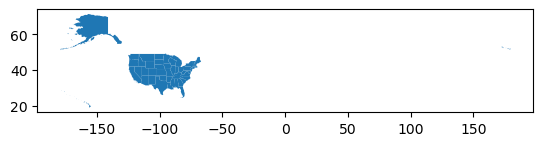

In [59]:
geo_df.plot()

In [60]:
test=geo_df.loc[~geo_df['STUSPS'].isin(['AK','HI'])]

Map saved to graphics_images/us_average_income_map_20241119_160548.png


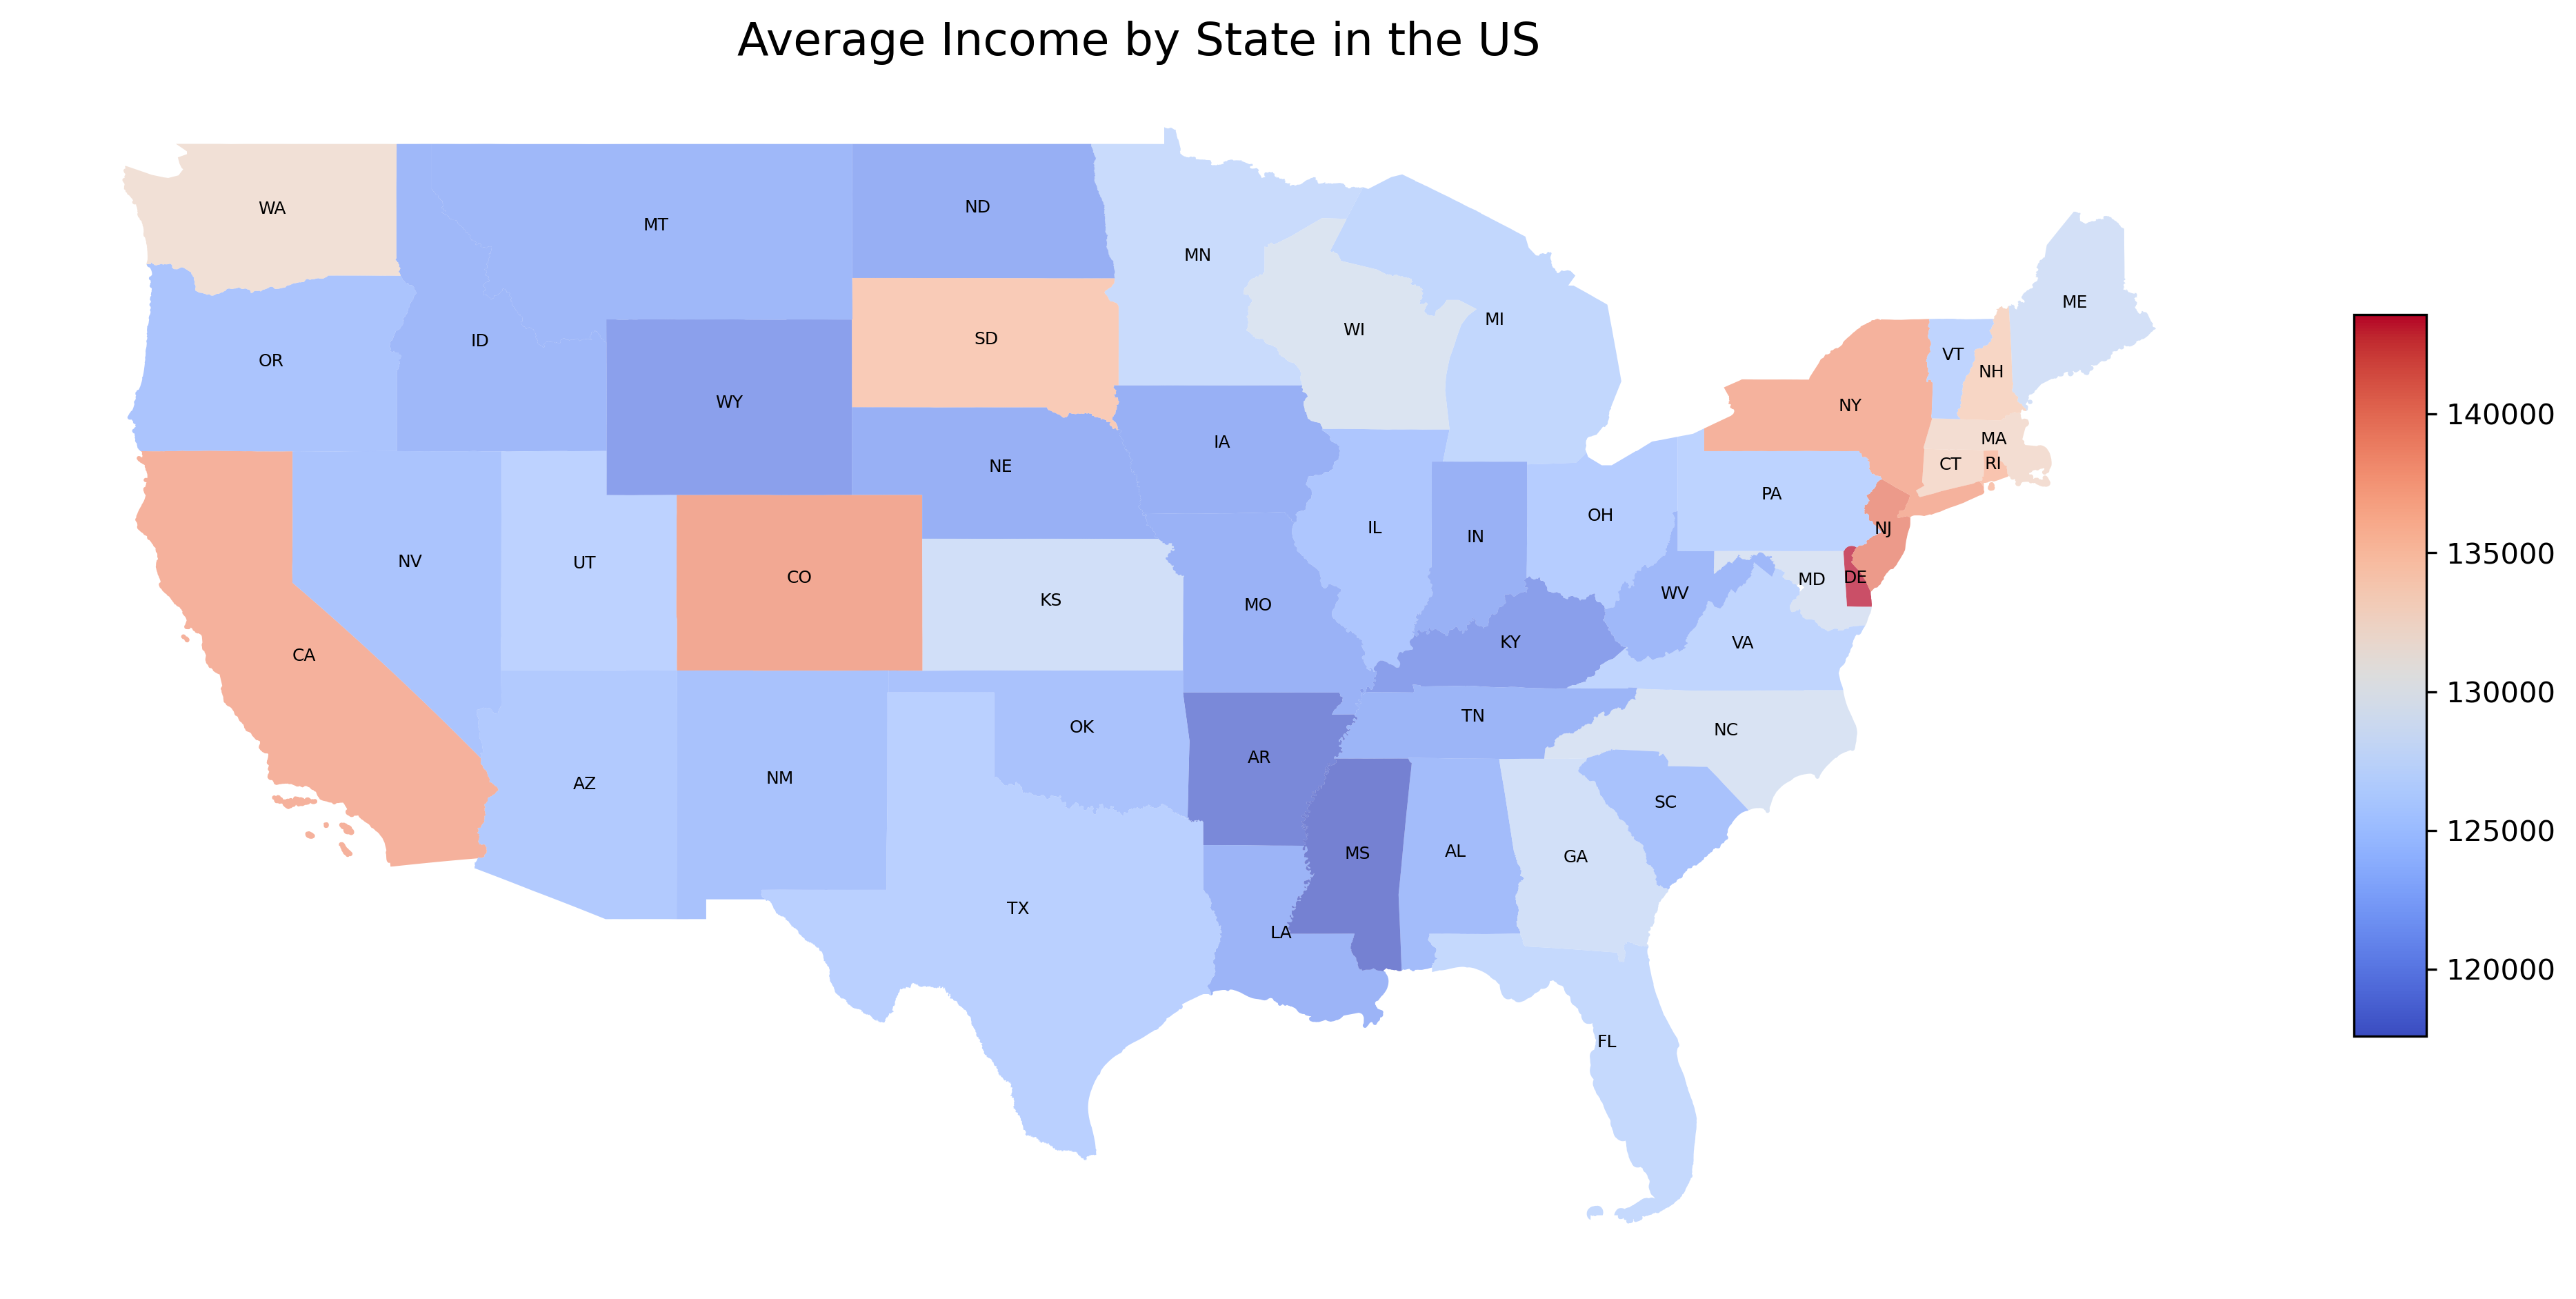

In [61]:
# Call the fucntion
StatesPlot(test, income_column='Annual Mean Wage', cmap='coolwarm', label_color='Black', label_size=6, 
title='Average Income by State in the US', filename='us_average_income_map.png')

#### Interpretaion

Delaware has the highest concentration of high-paid individuals, based on the annual mean wage data. This distinction may be attributed to its status as a hub for corporate headquarters and financial services.

Other Top States:
- New York: With its dominance in industries such as finance, media, and technology, New York ranks second.
- California: Known for its thriving technology and entertainment sectors, California secures the third position.
- Colorado: Emerging industries like technology, aerospace, and energy significantly contribute to its high rankings.
- New Jersey: Its proximity to New York City, coupled with a robust pharmaceutical and finance sector, makes New Jersey a strong contender.
Geographic Distribution:

> States with urban centers and a strong presence of high-paying industries generally perform better. Coastal states, particularly in the Northeast and West Coast, exhibit a clear advantage over their inland counterparts.

Visualization Highlights:
- Color Intensity: Darker shades on the map represent states with higher average annual wages.
- Clusters of Wealth: States in the Mid-Atlantic and West Coast dominate, showcasing clear contrasts with less urbanized states.

Delaware leading is based on average annual wages per individual (relative concentration of high-paid individuals).


## 5. Exploratory Data Analysis

1. What is the distribution of high-paid individuals across different states?

- Plot 1: Bar plot showing the number of high-paid individuals by state.


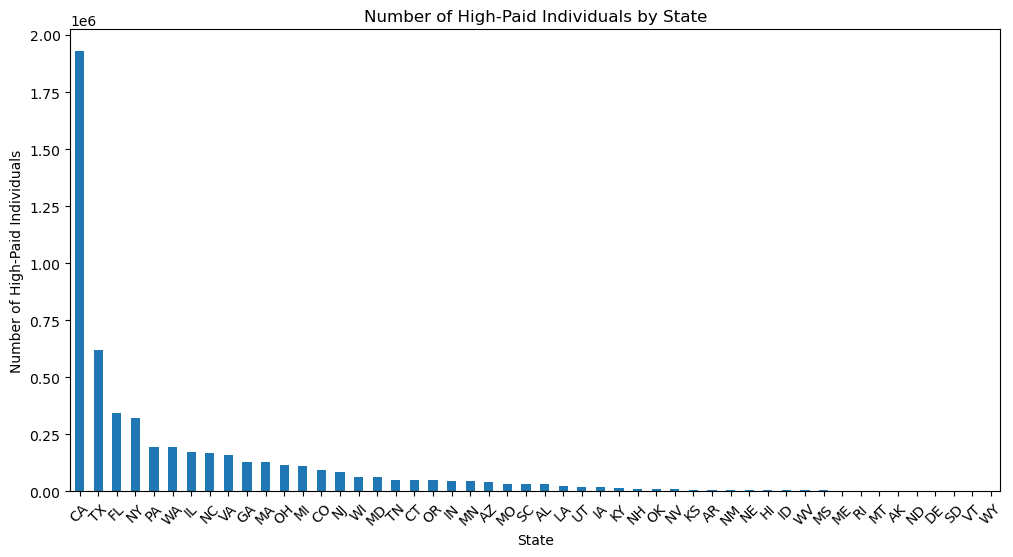

In [62]:
# 1. Distribution of high-paid individuals across different states
# Plot 1: Bar plot
plt.figure(figsize=(12, 6))
merged_df['State Abbriviation'].value_counts().plot(kind='bar')
plt.title('Number of High-Paid Individuals by State')
plt.xlabel('State')
plt.ylabel('Number of High-Paid Individuals')
plt.xticks(rotation=45)
plt.show()

- Plot 2: Pie chart showing the percentage of high-paid individuals by state.

In [63]:
#Group states with less than a certain threshold into "Other"
threshold = 0.05  # 5% threshold
state_counts = merged_df['State Abbriviation'].value_counts()

# Calculate the percentage of each state
state_percentages = state_counts / state_counts.sum()

# Create a new Series for states above the threshold
filtered_state_counts = state_counts[state_percentages >= threshold]

# Add "Other" category for states below the threshold
other_count = state_counts[state_percentages < threshold].sum()
if other_count > 0:
    filtered_state_counts['Other'] = other_count

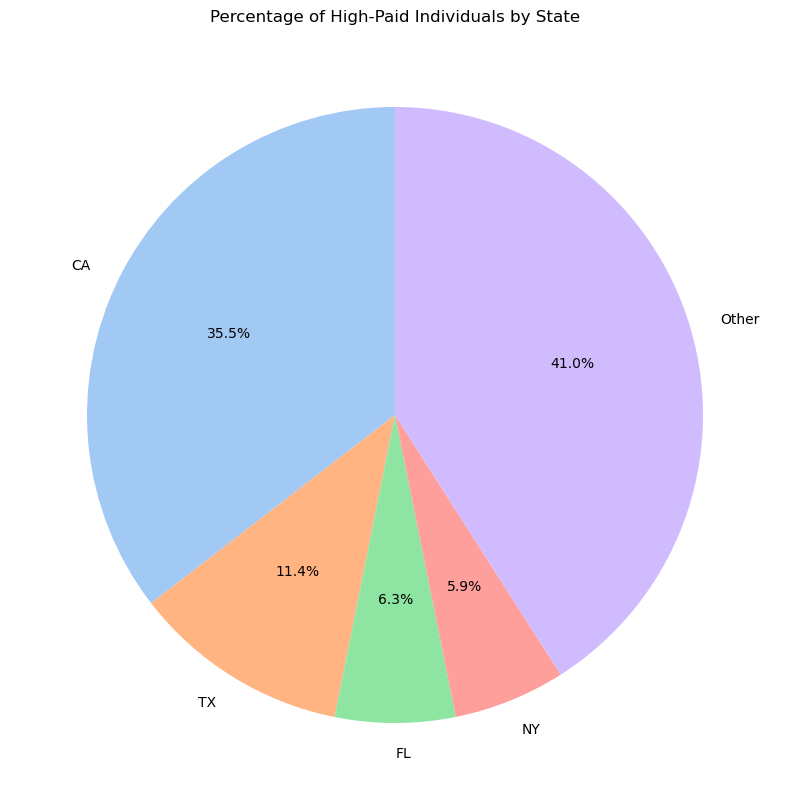

<Figure size 640x480 with 0 Axes>

In [65]:
# Plot the pie chart
plt.figure(figsize=(10, 10))
filtered_state_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title('Percentage of High-Paid Individuals by State')
plt.ylabel('')  # Hide the y-label
plt.show()
plt.savefig('./graphics_images/Pie_chart_high_paid_by_state.png')

Interpretation: reflect absolute numbers of high-paid individuals due to the sheer population size of these states. For example, California has a larger population, resulting in a higher total number of high-income earners, even if the average income is not the highest.

2. What are the most common occupations among high-paid individuals?

- Plot 1: Bar plot showing the top occupations for high-paid individuals.


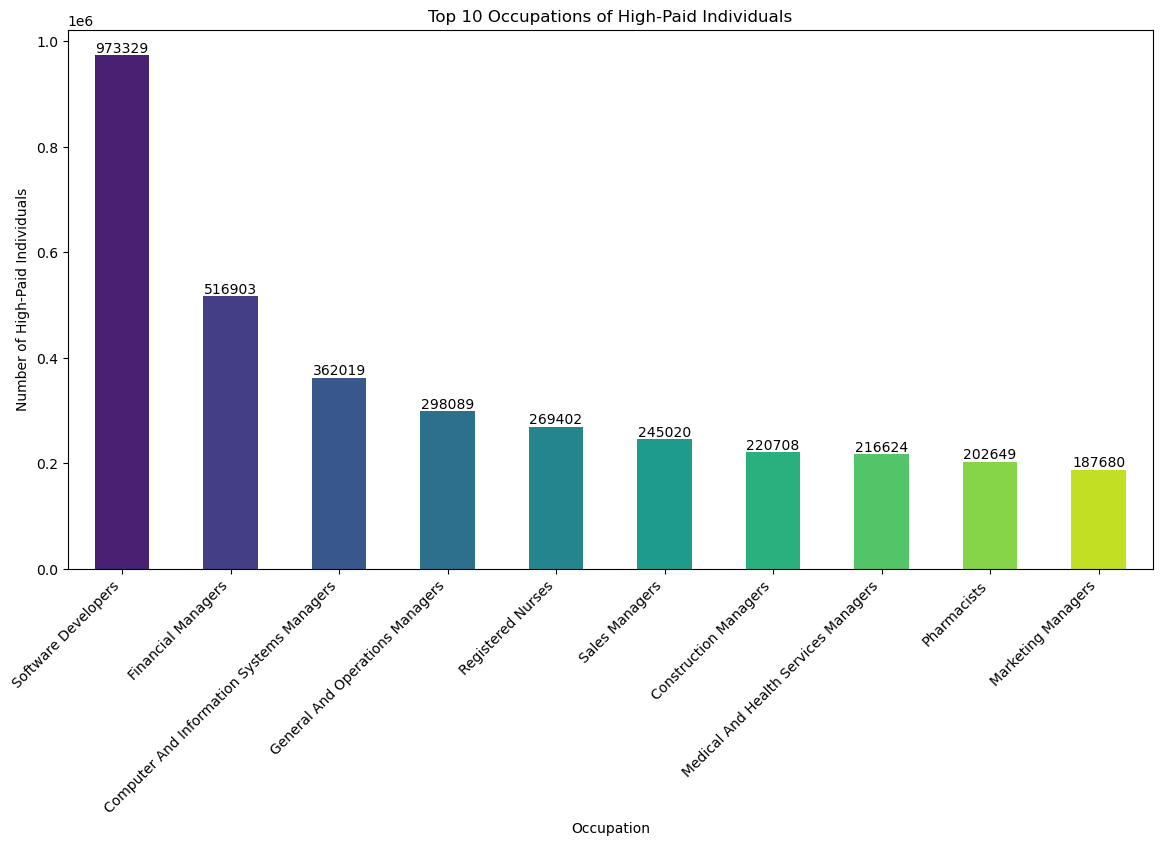

In [66]:
# Plot 1: Bar plot with a color palette
plt.figure(figsize=(14, 7))
top_occupations = merged_df['Occupation Title'].value_counts().head(10)
colors = sns.color_palette("viridis", len(top_occupations))  # Use a color palette

top_occupations.plot(kind='bar', color=colors)
plt.title('Top 10 Occupations of High-Paid Individuals')
plt.xlabel('Occupation')
plt.ylabel('Number of High-Paid Individuals')
plt.xticks(rotation=45, ha='right')

# Add text labels on top of the bars
for p in plt.gca().patches:
    plt.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom', fontsize=10)

plt.show()

- **Plot 2**: Horizontal bar plot for better readability of occupation names.


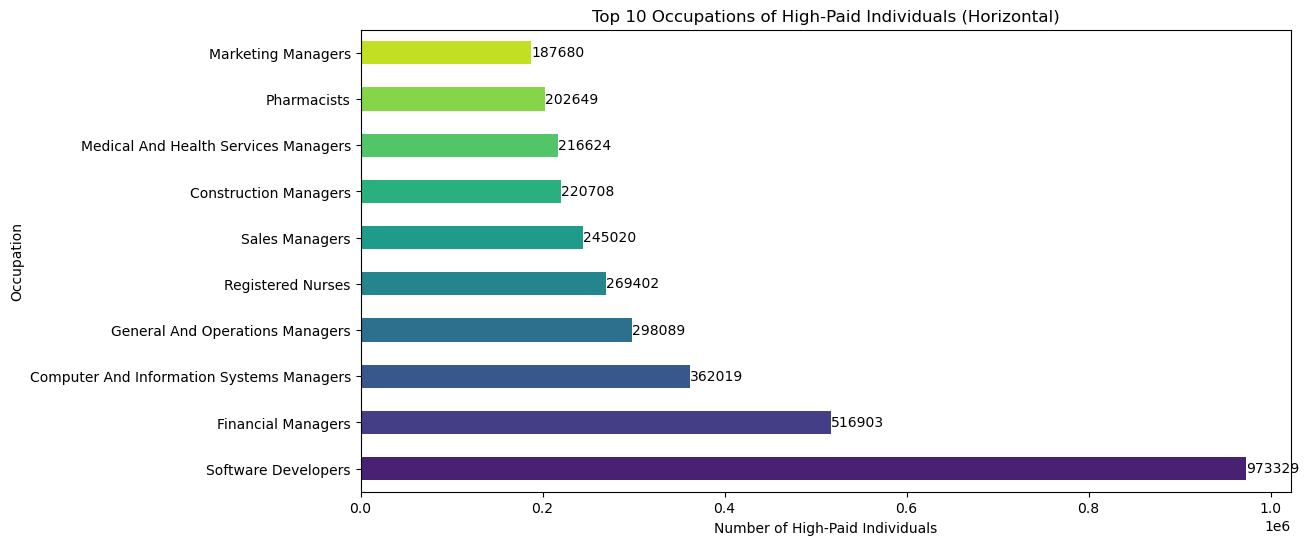

<Figure size 640x480 with 0 Axes>

In [68]:
# Plot 2: Horizontal bar plot with a color palette
plt.figure(figsize=(12, 6))
top_occupations = merged_df['Occupation Title'].value_counts().head(10)

# Use a color palette
colors = sns.color_palette("viridis", len(top_occupations))  # Choose a color palette

top_occupations.plot(kind='barh', color=colors)
plt.title('Top 10 Occupations of High-Paid Individuals (Horizontal)')
plt.xlabel('Number of High-Paid Individuals')
plt.ylabel('Occupation')

# Add text labels on the bars
for index, value in enumerate(top_occupations):
    plt.text(value, index, str(value), va='center')  # Add text labels

plt.show()
plt.savefig('./graphics_images/top_10_OCC_high_paid_indv.png')

Interpretaion :
- Tech Dominance: The top occupations indicate a strong representation from the technology sector, emphasizing its role as a high-paying industry.
Financial Sector Presence: Financial managers' inclusion highlights the importance of financial expertise in driving organizational success.
Management Roles: Both IT and financial management roles underscore the premium paid for leadership positions in specialized fields.
- This visualization reinforces the idea that the highest-paying jobs are often in high-demand, specialized fields like software development and financial management. These sectors require specific skill sets and leadership, which are highly compensated across different regions.

3. What is the relationship between education level and the number of high-paid individuals?

- **Plot 1:** Bar plot showing the number of high-paid individuals by education level.


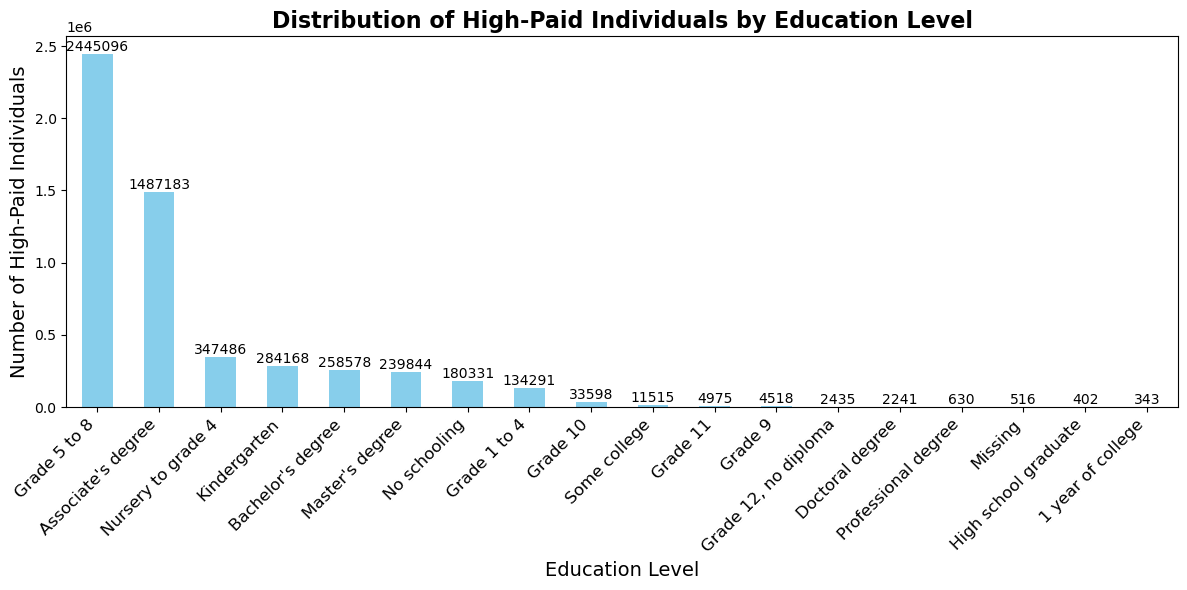

<Figure size 640x480 with 0 Axes>

In [69]:
# 3. Relationship between education level and high-paid individuals
# Plot 1: Bar plot
plt.figure(figsize=(12, 6))
education_counts = merged_df['Education Level'].value_counts()
education_counts.plot(kind='bar', color='skyblue')

# Title and labels
plt.title('Distribution of High-Paid Individuals by Education Level', fontsize=16, fontweight='bold')
plt.xlabel('Education Level', fontsize=14)
plt.ylabel('Number of High-Paid Individuals', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)

# Adding value annotations on top of the bars
for index, value in enumerate(education_counts):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10)

plt.tight_layout()  # Adjust layout to make room for labels
plt.show()
plt.savefig('./graphics_images/High_paid_by_Education_Level.png')


- **Plot 2:** Box plot showing the distribution of salaries by education level.


C:\Users\Sami\AppData\Local\Temp\ipykernel_387928\3056857032.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Education Level', y='Annual Mean Wage', data=merged_df, order=education_order, palette='Set2')


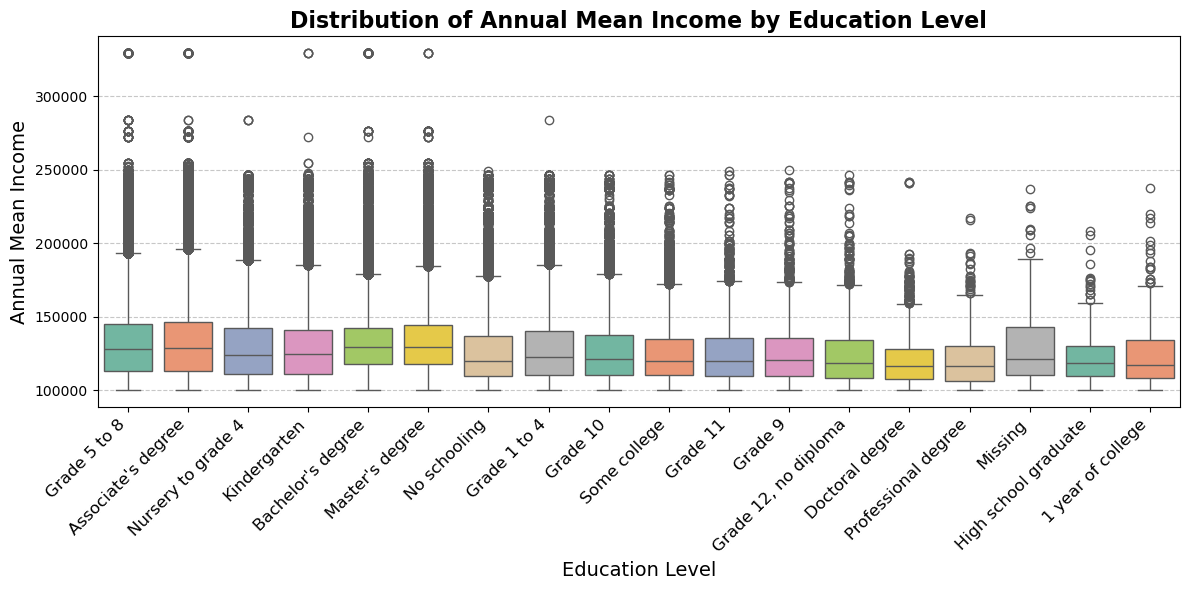

<Figure size 640x480 with 0 Axes>

In [71]:
# Plot 2: Box plot
# Define a custom order for education levels if needed
education_order = merged_df['Education Level'].value_counts().index.tolist()

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Education Level', y='Annual Mean Wage', data=merged_df, order=education_order, palette='Set2')

# Title and labels
plt.title('Distribution of Annual Mean Income by Education Level', fontsize=16, fontweight='bold')
plt.xlabel('Education Level', fontsize=14)
plt.ylabel('Annual Mean Income', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)

# Adding grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()  # Adjust layout to make room for labels
plt.show()
plt.savefig('./graphics_images/Salary_by_ Education_Level.png')

The high incomes for individuals with "Grade 5 to 8," "Associate Degree," and "Nursing to Grade 4" can be explained by the demand for skilled trades and healthcare roles, which require specialized training rather than a four-year degree. These fields, such as nursing and technical professions, offer high salaries due to expertise, certifications, and the labor market's need for skilled workers

4. What is the correlation between salary (A_MEAN) and other numerical features?


In [72]:
# Select only numerical columns from the DataFrame
numerical_columns = merged_df.select_dtypes(include=['float64', 'int64']).columns

# Calculate the correlation matrix
correlation_matrix = merged_df[numerical_columns].corr()

# Filter the correlation to show only the correlation of 'A_MEAN' with other numerical features
salary_correlation = correlation_matrix['Annual Mean Wage'].sort_values(ascending=False)

# Display the correlation values
print(salary_correlation)



Annual Mean Wage      1.000000
Hourly Mean Wage      1.000000
Annual Median Wage    0.894556
Hourly Median Wage    0.894553
Total Employment      0.153764
State code            0.105746
Education Code        0.068410
Age                  -0.027021
Name: Annual Mean Wage, dtype: float64


- **Plot 1:** Heatmap showing the correlation matrix of numerical features.

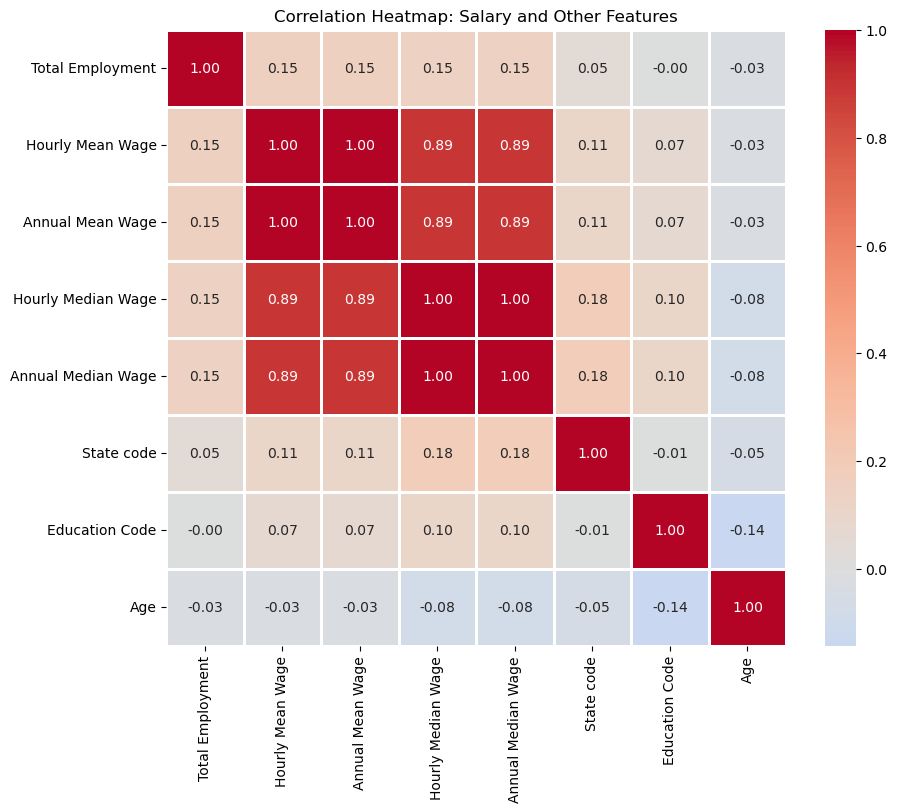

<Figure size 640x480 with 0 Axes>

In [73]:
# Plot heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=1, linecolor='white', fmt=".2f")
plt.title('Correlation Heatmap: Salary and Other Features')
plt.show()
plt.savefig('./graphics_images/Correlation.png')


The small correlation (max 0.15) suggests that salary is influenced by many factors in complex ways, not just the numerical features. It could be due to non-linear relationships, diverse salary ranges across industries, or the presence of outliers, making it hard to capture strong linear correlations.

- **Plot 2:** Scatter plot showing the relationship between A_MEAN and TOT_EMP.

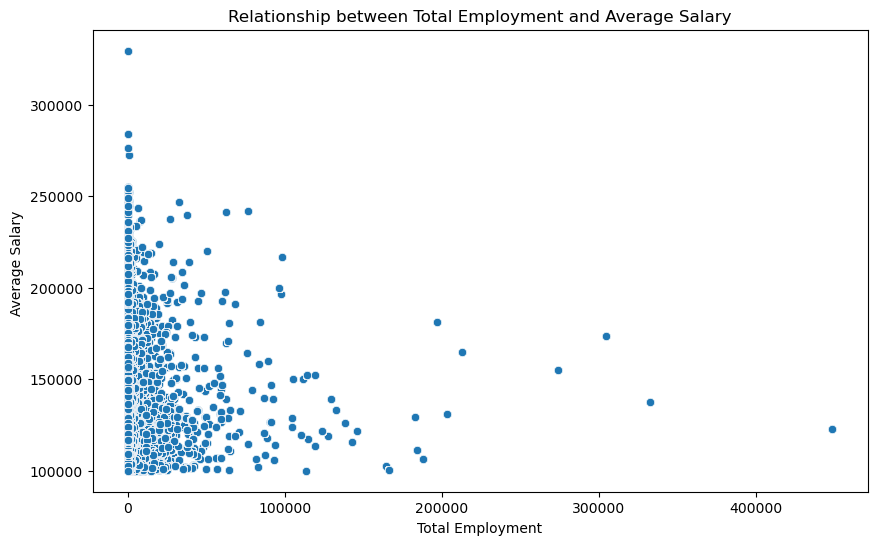

<Figure size 640x480 with 0 Axes>

In [74]:
# Plot 2: Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total Employment', y='Annual Mean Wage', data=merged_df)
plt.title('Relationship between Total Employment and Average Salary')
plt.xlabel('Total Employment')
plt.ylabel('Average Salary ')
plt.show()
plt.savefig('./graphics_images/Relationship_between_Total_Employment_and_Average_Salary.png')

5. What is the distribution of high-paid individuals by gender?

- Plot 1: Count of High-Paid Individuals by Gender

C:\Users\Sami\AppData\Local\Temp\ipykernel_387928\3526829368.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender', data=merged_df, palette=['blue','pink'])


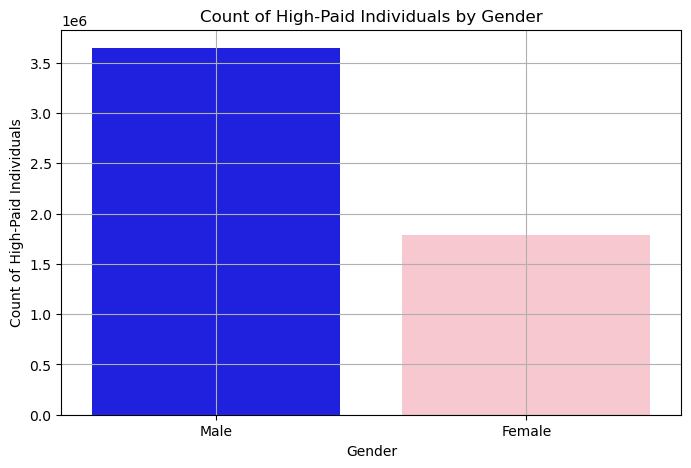

<Figure size 640x480 with 0 Axes>

In [77]:
# Count of high-paid individuals by gender
plt.figure(figsize=(8, 5))
sns.countplot(x='Gender', data=merged_df, palette=['blue','pink'])
plt.title('Count of High-Paid Individuals by Gender')
plt.xlabel('Gender')
plt.ylabel('Count of High-Paid Individuals')
plt.grid()
plt.show()
plt.savefig('./graphics_images/Count_of_High-Paid_Individuals_by_Gender.png')

- Plot 2: Average Annual Mean Wage by Gender

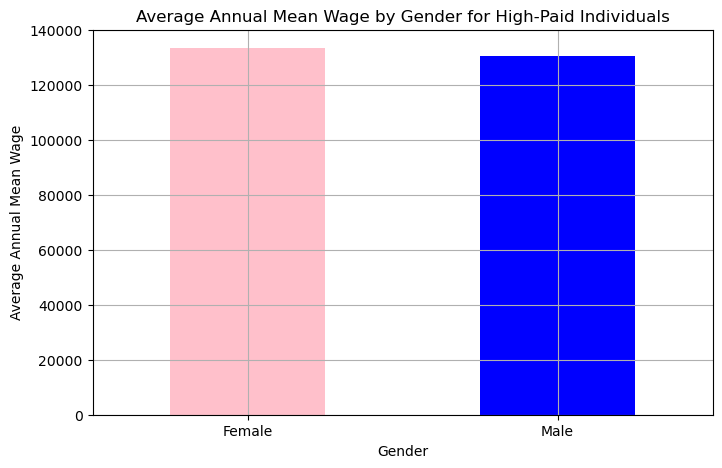

<Figure size 640x480 with 0 Axes>

In [78]:
# Average Annual Mean Wage by Gender
avg_wages_by_gender = merged_df.groupby('Gender')['Annual Mean Wage'].mean()

plt.figure(figsize=(8, 5))
avg_wages_by_gender.plot(kind='bar', color=['pink', 'blue'])
plt.title('Average Annual Mean Wage by Gender for High-Paid Individuals')
plt.xlabel('Gender')
plt.ylabel('Average Annual Mean Wage')
plt.xticks(rotation=0)
plt.grid()
plt.show()
plt.savefig('./graphics_images/Ave_A_Wage_by_Gender_for_High-Paid_Individuals.png')

The results show that in the count of high-paid individuals by gender, males dominate, which is often reflective of the overall gender disparity in high-paying occupations and leadership roles. This is consistent with many industries where more males are in top-paying positions.

However, in the average annual mean wage by gender, females show a slight dominance, suggesting that within the specific high-paying roles analyzed, women may be earning slightly more on average. This could reflect a few things:

- Differences in Occupations: High-paying jobs for women may be concentrated in fields that offer slightly higher wages.
- Smaller Sample Size for Women: There could be fewer women in the data, but their salaries might skew higher due to fewer women in the job market at the high end.
- Sector Differences: Certain sectors, such as healthcare or education, might have fewer men but offer high-paying opportunities for women, leading to a higher average wage.
>The slight difference in wages might also indicate that the top earners in some fields may be women, even though more men hold high-paying roles in other industries.


6. How does the average salary vary across different occupation?

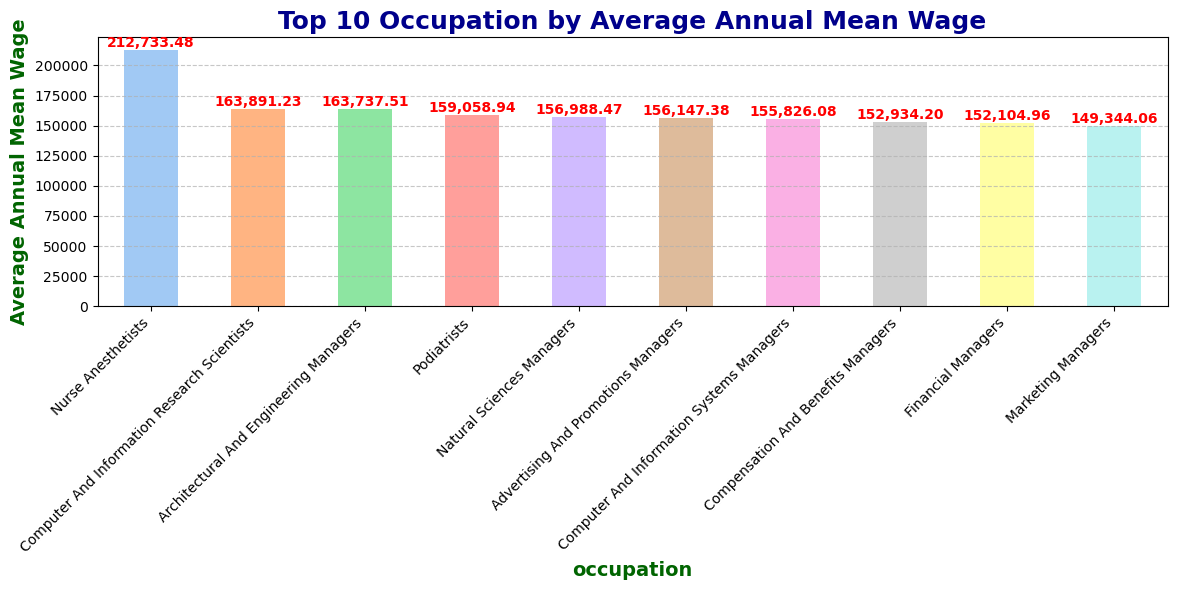

<Figure size 640x480 with 0 Axes>

In [79]:
# # Average Annual Mean Wage by occupation
# Step 1: Calculate the average annual mean wage for each occupation
avg_wages_by_industry = merged_df.groupby('Occupation Title')['Annual Mean Wage'].mean().sort_values(ascending=False)

# Step 2: Create the bar plot for the top 10 industries
plt.figure(figsize=(12, 6))
bars = avg_wages_by_industry.head(10).plot(kind='bar', color=sns.color_palette("pastel", 10))

# Step 3: Add titles and labels with increased font size and color
plt.title('Top 10 Occupation by Average Annual Mean Wage', fontsize=18, fontweight='bold', color='darkblue')
plt.xlabel('occupation', fontsize=14, fontweight='bold', color='darkgreen')
plt.ylabel('Average Annual Mean Wage', fontsize=14, fontweight='bold', color='darkgreen')
plt.xticks(rotation=45, ha='right', fontsize=10, color='black')  # Reduced fontsize to 10
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Step 4: Add data labels on top of the bars with contrasting color
for bar in bars.patches:
    bars.annotate(f'{bar.get_height():,.2f}', 
                  (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                  ha='center', va='bottom', fontsize=10, color='red', fontweight='bold')

plt.tight_layout()  # Adjust layout to make room for labels
plt.show()
plt.savefig('./graphics_images/Top_10_Occupation_by_Average_Annual_Mean_Wage.png')

C:\Users\Sami\AppData\Local\Temp\ipykernel_387928\2313770689.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Occupation Title', y='Annual Mean Wage', data=filtered_df, palette='Set2')


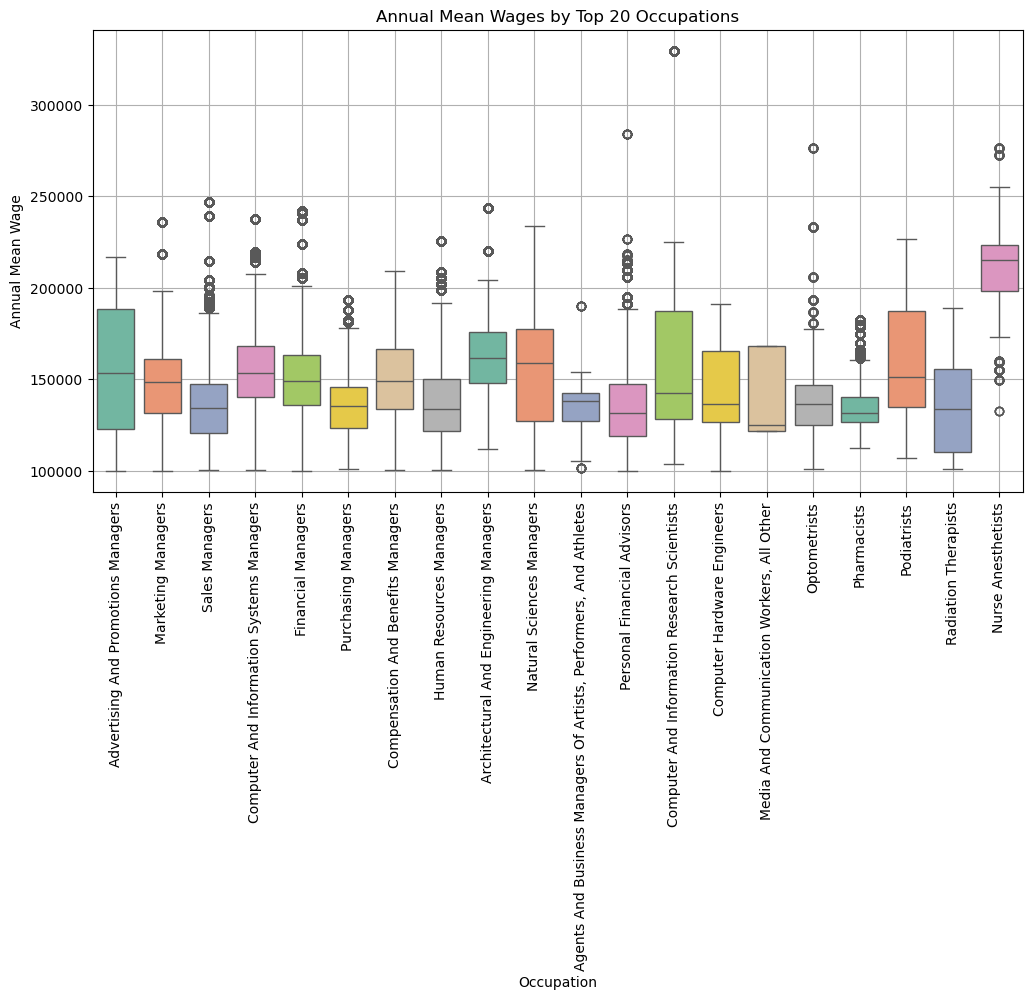

<Figure size 640x480 with 0 Axes>

In [80]:
# # Boxplot of Annual Mean Wages by OCCupation
# Step 1: Calculate the average annual mean wage for each occupation
avg_wages_by_occupation = merged_df.groupby('Occupation Title')['Annual Mean Wage'].mean().sort_values(ascending=False)
# Step 2: Select the top 20 occupations
top_20_occupations = avg_wages_by_occupation.head(20).index
filtered_df = merged_df[merged_df['Occupation Title'].isin(top_20_occupations)]
# Step 3: Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Occupation Title', y='Annual Mean Wage', data=filtered_df, palette='Set2')
plt.xticks(rotation=90)
plt.title('Annual Mean Wages by Top 20 Occupations')
plt.xlabel('Occupation')
plt.ylabel('Annual Mean Wage')
plt.grid()
plt.show()
plt.savefig('./graphics_images/Annual_Mean_Wages_by_Top_20_Occupations.png')

7. How is the distribution of high-paid individuals across different age groups?

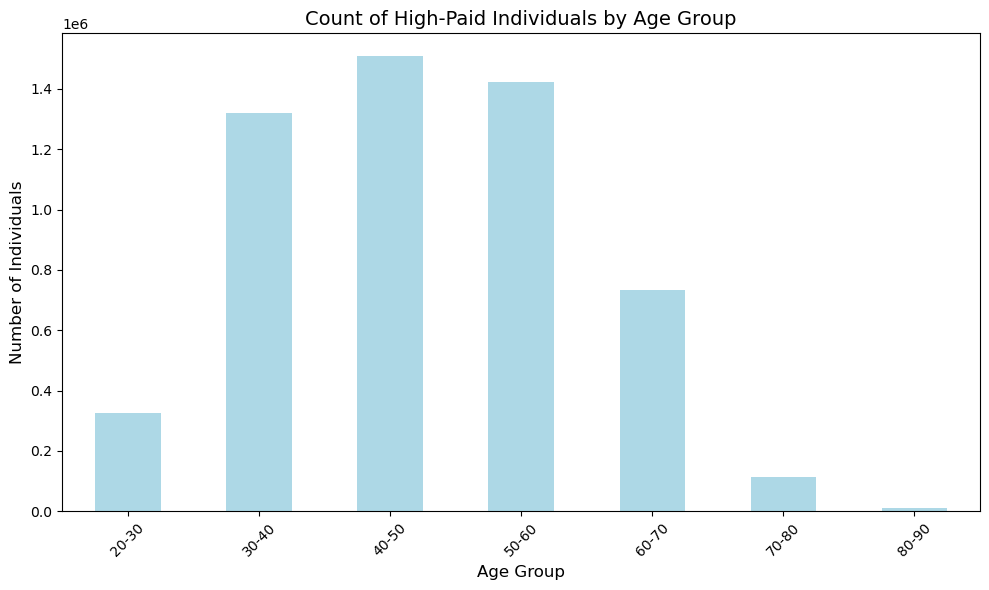

<Figure size 640x480 with 0 Axes>

In [81]:
# Create age groups for better visualization (e.g., 20-30, 30-40, etc.)
bins = [20, 30, 40, 50, 60, 70, 80, 90]
labels = ['20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90']
merged_df['Age_grp'] = pd.cut(merged_df['Age'], bins=bins, labels=labels, right=False)

# Plot 1: Count of High-Paid Individuals by Age Group
plt.figure(figsize=(10, 6))
merged_df['Age_grp'].value_counts().sort_index().plot(kind='bar', color='lightblue')
plt.title('Count of High-Paid Individuals by Age Group', fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Number of Individuals', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('./graphics_images/High-Paid_Individuals_by_Age_Group.png')